## Evaluate ictality alerting
Noam Siegel, Ben Gurion University

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pytorch_lightning import seed_everything
from sklearn import mixture
from sklearn.metrics import RocCurveDisplay

from msc.plot_utils import add_tsne_to_df
from msc.results_collectors import GPResultsCollector

seed_everything(42)
% load_ext autoreload
% autoreload 2

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\noam\.virtualenvs\msc-WSmVxSSb\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 42


## Load all embeddings
version 0.1.0
from CSV

In [4]:
results_fpath = r"C:\Users\noam\Repositories\noamsgl\msc\results\results-21-2-22\results.csv"
results_df = pd.read_csv(results_fpath, index_col=0)

## Drop Nans

In [16]:
results_df = results_df.dropna(subset=['train_loss'])

## Add test answer keys

In [43]:
# load answer keys
test_answer_key_fpath = r"C:\Users\noam\Repositories\noamsgl\msc\data\seizure-detection\SzDetectionAnswerKey.csv"
test_labels = pd.read_csv(test_answer_key_fpath)
test_labels['clip_name'] = test_labels['clip'].apply(lambda fname: fname[:-4])
# add answer keys to results
results_df = pd.merge(results_df, test_labels, how='left',on="clip_name")

In [44]:
results_df

,train_loss,likelihood.raw_task_noises[0],likelihood.raw_task_noises[1],likelihood.raw_noise,covar_module.task_covar_module.covar_factor[0],covar_module.task_covar_module.covar_factor[1],covar_module.task_covar_module.raw_var[0],covar_module.task_covar_module.raw_var[1],covar_module.data_covar_module.raw_lengthscale,epoch,...,clip_name,label_desc,version,num_channels,likelihood.raw_task_noises,covar_module.task_covar_module.covar_factor,covar_module.task_covar_module.raw_var,clip,seizure,early
0,-0.366232,-6.322467,-6.429121,-6.381074,0.346284,0.365560,-0.452325,-1.079334,-4.181092,999.0,...,Dog_1_ictal_segment_1,ictal,0.1.0,2,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.289474,NaN,NaN,-6.351304,NaN,NaN,NaN,NaN,-4.189489,999.0,...,Dog_1_ictal_segment_1,ictal,0.1.0,1,-6.351304,0.206774,-0.281881,NaN,NaN,NaN
2,-0.430646,NaN,NaN,-6.359039,NaN,NaN,NaN,NaN,-4.094140,999.0,...,Dog_1_ictal_segment_1,ictal,0.1.0,1,-6.359039,0.111852,-0.456813,NaN,NaN,NaN
3,-0.311700,-6.604381,-6.209981,-6.452849,0.468721,0.572521,-0.986530,-0.482866,-4.171540,999.0,...,Dog_1_ictal_segment_1,ictal,0.1.0,2,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.393655,NaN,NaN,-6.485181,NaN,NaN,NaN,NaN,-3.985386,999.0,...,Dog_1_ictal_segment_1,ictal,0.1.0,1,-6.485181,0.316019,-0.084873,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41003,-0.748452,NaN,NaN,-7.305155,NaN,NaN,NaN,NaN,-3.984214,999.0,...,Dog_1_test_segment_2075,test,0.1.0,1,-7.305155,0.020434,-0.698031,Dog_1_test_segment_2075.mat,-1.0,0.0
41004,-0.842039,NaN,NaN,-7.000558,NaN,NaN,NaN,NaN,-4.172774,999.0,...,Dog_1_test_segment_2075,test,0.1.0,1,-7.000558,0.000057,-1.809473,Dog_1_test_segment_2075.mat,-1.0,0.0
41005,-0.717861,NaN,NaN,-7.029493,NaN,NaN,NaN,NaN,-3.685556,999.0,...,Dog_1_test_segment_2075,test,0.1.0,1,-7.029493,0.341225,-0.201487,Dog_1_test_segment_2075.mat,-1.0,0.0
41006,-0.599081,NaN,NaN,-7.075176,NaN,NaN,NaN,NaN,-4.087623,999.0,...,Dog_1_test_segment_2075,test,0.1.0,1,-7.075176,0.091386,-0.621841,Dog_1_test_segment_2075.mat,-1.0,0.0


In [20]:
results_df.columns,

Index(['train_loss', 'likelihood.raw_task_noises[0]',
       'likelihood.raw_task_noises[1]', 'likelihood.raw_noise',
       'covar_module.task_covar_module.covar_factor[0]',
       'covar_module.task_covar_module.covar_factor[1]',
       'covar_module.task_covar_module.raw_var[0]',
       'covar_module.task_covar_module.raw_var[1]',
       'covar_module.data_covar_module.raw_lengthscale', 'epoch', 'step',
       'ch_names', 'clip_name', 'label_desc', 'version', 'num_channels',
       'likelihood.raw_task_noises',
       'covar_module.task_covar_module.covar_factor',
       'covar_module.task_covar_module.raw_var'],
      dtype='object')

In [45]:
single_channel_params = ['covar_module.data_covar_module.raw_lengthscale',
                         'covar_module.task_covar_module.covar_factor', 'covar_module.task_covar_module.raw_var']
double_channel_params = ['covar_module.task_covar_module.covar_factor[0]',
                         'covar_module.task_covar_module.covar_factor[1]',
                         'covar_module.task_covar_module.raw_var[0]',
                         'covar_module.task_covar_module.raw_var[1]',
                         'covar_module.data_covar_module.raw_lengthscale']

In [144]:
single_results_df = results_df.loc[results_df['num_channels'] == 1, single_channel_params + ['label_desc'] + ['clip_name'] + ['seizure']]
single_results_df

,covar_module.data_covar_module.raw_lengthscale,covar_module.task_covar_module.covar_factor,covar_module.task_covar_module.raw_var,label_desc,clip_name,seizure
1,-4.189489,0.206774,-0.281881,ictal,Dog_1_ictal_segment_1,NaN
2,-4.094140,0.111852,-0.456813,ictal,Dog_1_ictal_segment_1,NaN
4,-3.985386,0.316019,-0.084873,ictal,Dog_1_ictal_segment_1,NaN
5,-4.239130,0.332558,-0.212837,ictal,Dog_1_ictal_segment_1,NaN
7,-4.159550,0.163072,-0.399358,ictal,Dog_1_ictal_segment_1,NaN
...,...,...,...,...,...,...
41003,-3.984214,0.020434,-0.698031,test,Dog_1_test_segment_2075,-1.0
41004,-4.172774,0.000057,-1.809473,test,Dog_1_test_segment_2075,-1.0
41005,-3.685556,0.341225,-0.201487,test,Dog_1_test_segment_2075,-1.0
41006,-4.087623,0.091386,-0.621841,test,Dog_1_test_segment_2075,-1.0


In [48]:
double_results_df = results_df.loc[results_df['num_channels'] == 2, double_channel_params + ['label_desc'] + ['clip_name'] + ['seizure']]
double_results_df

,covar_module.task_covar_module.covar_factor[0],covar_module.task_covar_module.covar_factor[1],covar_module.task_covar_module.raw_var[0],covar_module.task_covar_module.raw_var[1],covar_module.data_covar_module.raw_lengthscale,label_desc,clip_name,seizure
0,0.346284,0.365560,-0.452325,-1.079334,-4.181092,ictal,Dog_1_ictal_segment_1,NaN
3,0.468721,0.572521,-0.986530,-0.482866,-4.171540,ictal,Dog_1_ictal_segment_1,NaN
6,0.533905,0.628705,-2.208740,-1.927185,-4.388024,ictal,Dog_1_ictal_segment_1,NaN
9,0.667333,0.301694,0.939679,-0.839994,-4.190533,ictal,Dog_1_ictal_segment_1,NaN
11,-0.051277,0.348626,1.393423,0.907051,-3.915130,ictal,Dog_1_ictal_segment_1,NaN
...,...,...,...,...,...,...,...,...
38071,-0.073962,-0.118927,-3.461426,-3.277023,-4.660611,test,Dog_1_test_segment_1910,-1.0
38074,0.163001,0.178441,-3.272478,-3.830204,-4.725718,test,Dog_1_test_segment_1910,-1.0
38077,0.038648,0.208553,-3.053872,-3.090405,-4.894453,test,Dog_1_test_segment_1910,-1.0
38080,0.248586,0.044722,-2.145833,-2.694724,-4.851481,test,Dog_1_test_segment_1910,-1.0


In [122]:
# single_results_df = add_tsne_to_df(single_results_df, single_channel_params)

## Estimate interictal embeddings density

In [193]:
# fit a Gaussian Mixture Model with two components to the interictal training clips
gmm = mixture.GaussianMixture(n_components=2, covariance_type="full")
gmm.fit(single_results_df.loc[single_results_df['label_desc'] == 'interictal', single_channel_params].values)

GaussianMixture(n_components=2)

In [194]:
# compute negative log likelihood (novelty score) for all clips
single_results_df["nll"] = single_results_df.apply(lambda row: -gmm.score(np.array(row[single_channel_params]).reshape(1, -1)), axis=1)

In [195]:
# compute p_values for all clips
interictals = single_results_df.loc[single_results_df['label_desc'] == 'interictal']
single_results_df['p_value'] = single_results_df.apply(
    lambda row: (len(interictals.loc[interictals["nll"] < row['nll']])) / len(interictals), axis=1)

In [196]:
# fit a Gaussian Mixture Model with two components to the interictal training clips
gmm = mixture.GaussianMixture(n_components=2, covariance_type="full")
gmm.fit(double_results_df.loc[double_results_df['label_desc'] == 'interictal', double_channel_params].values)

GaussianMixture(n_components=2)

In [197]:
# compute negative log likelihood (novelty score) for all clips
double_results_df["nll"] = double_results_df.apply(lambda row: -gmm.score(np.array(row[double_channel_params]).reshape(1, -1)), axis=1)

In [198]:
# compute p_values for all clips
interictals = double_results_df.loc[double_results_df['label_desc'] == 'interictal']
double_results_df['p_value'] = double_results_df.apply(
    lambda row: (len(interictals.loc[interictals["nll"] < row['nll']])) / len(interictals), axis=1)

## Visually explore results

In [164]:
single_results_df = add_tsne_to_df(single_results_df, single_channel_params, label_desc='test', perplexity=10.0)
# embeddings = add_tsne_to_df(double_results_df, double_channel_params)

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [174]:
double_results_df = add_tsne_to_df(double_results_df, double_channel_params, label_desc='test')

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [239]:
from msc.plot_utils import add_pca_to_df

double_results_df = add_pca_to_df(double_results_df, double_channel_params, label_desc='test')

In [156]:
embeddings = single_results_df
# embeddings = double_results_df

In [157]:
embeddings

,covar_module.data_covar_module.raw_lengthscale,covar_module.task_covar_module.covar_factor,covar_module.task_covar_module.raw_var,label_desc,clip_name,seizure,tsne-2d-one,tsne-2d-two
1,-4.189489,0.206774,-0.281881,ictal,Dog_1_ictal_segment_1,NaN,NaN,NaN
2,-4.094140,0.111852,-0.456813,ictal,Dog_1_ictal_segment_1,NaN,NaN,NaN
4,-3.985386,0.316019,-0.084873,ictal,Dog_1_ictal_segment_1,NaN,NaN,NaN
5,-4.239130,0.332558,-0.212837,ictal,Dog_1_ictal_segment_1,NaN,NaN,NaN
7,-4.159550,0.163072,-0.399358,ictal,Dog_1_ictal_segment_1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
41003,-3.984214,0.020434,-0.698031,test,Dog_1_test_segment_2075,-1.0,-25.626869,95.764236
41004,-4.172774,0.000057,-1.809473,test,Dog_1_test_segment_2075,-1.0,33.236423,34.968487
41005,-3.685556,0.341225,-0.201487,test,Dog_1_test_segment_2075,-1.0,-65.259079,74.457245
41006,-4.087623,0.091386,-0.621841,test,Dog_1_test_segment_2075,-1.0,-28.594639,79.815132


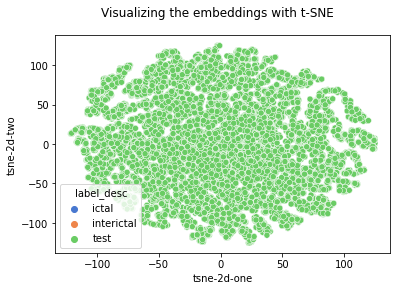

In [165]:
sns.scatterplot(data=embeddings.sort_values('label_desc', ascending=False),
                x='tsne-2d-one', y='tsne-2d-two',
                hue_order=['ictal', 'interictal', 'test'],
                hue="label_desc", palette="muted", legend=True)
plt.suptitle("Visualizing the embeddings with t-SNE")
plt.show()


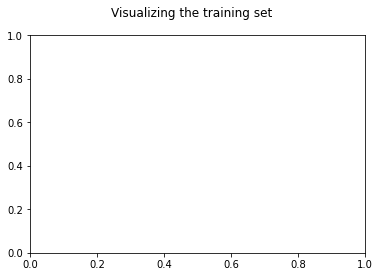

In [159]:
sns.scatterplot(data=embeddings.query("label_desc != 'test'"),
                x='tsne-2d-one', y='tsne-2d-two',
                hue="label_desc", palette="muted", legend=True)
plt.suptitle("Visualizing the training set")
plt.show()


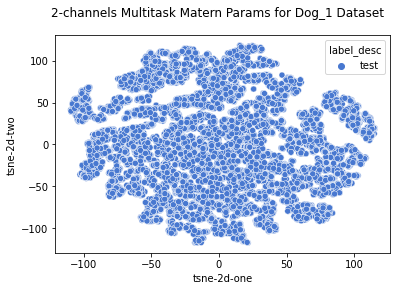

In [160]:
sns.scatterplot(data=embeddings.query("label_desc == 'test'"),
                x='tsne-2d-one', y='tsne-2d-two',
                # hue_order=hue_order,
                hue="label_desc", palette="muted", legend=True)
plt.suptitle("2-channels Multitask Matern Params for Dog_1 Dataset")
plt.show()


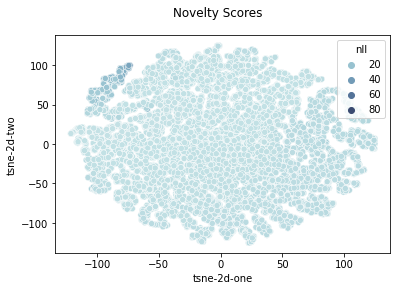

In [204]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

sns.scatterplot(data=embeddings,
                x='tsne-2d-one', y='tsne-2d-two',
                # hue_order=hue_order,
                hue="nll", palette=cmap, legend=True)
plt.suptitle("Novelty Scores")
plt.show()

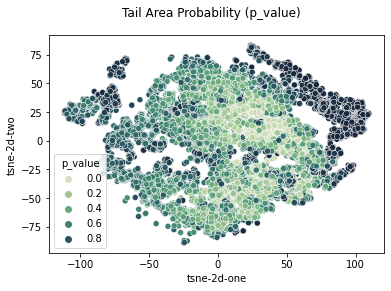

In [205]:
cmap = sns.cubehelix_palette(rot=-.55, as_cmap=True)

sns.scatterplot(data=double_results_df,
                x='tsne-2d-one', y='tsne-2d-two',
                # hue_order=hue_order,
                hue="p_value", palette=cmap, legend=True)
plt.suptitle("Tail Area Probability (p_value)")
plt.show()

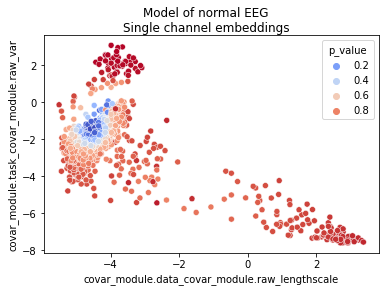

In [231]:
cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.scatterplot(data=single_results_df.query("label_desc == 'test'").sample(2000),
                x=single_channel_params[0], y=single_channel_params[2],
                # hue_order=hue_order,
                hue="p_value", palette=cmap, legend=True)
plt.suptitle("Model of normal EEG\nSingle channel embeddings")
plt.show()

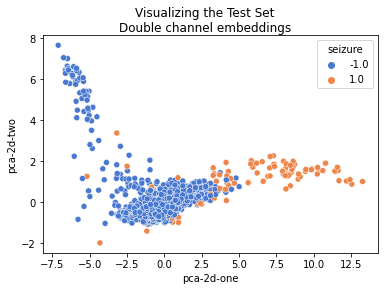

In [240]:
sns.scatterplot(data=double_results_df.query("label_desc == 'test'").sample(2000),
                x='pca-2d-one', y='pca-2d-two',
                # hue_order=hue_order,
                hue="seizure", palette="muted", legend=True)
plt.suptitle("Visualizing the Test Set\nDouble channel embeddings")
plt.show()

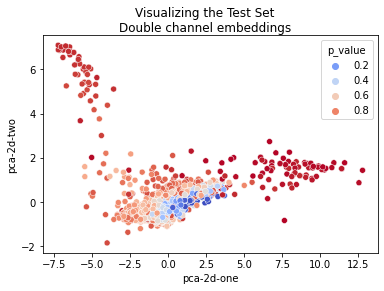

In [241]:
sns.scatterplot(data=double_results_df.query("label_desc == 'test'").sample(2000),
                x='pca-2d-one', y='pca-2d-two',
                # hue_order=hue_order,
                hue="p_value", palette=cmap, legend=True)
plt.suptitle("Visualizing the Test Set\nDouble channel embeddings")
plt.show()

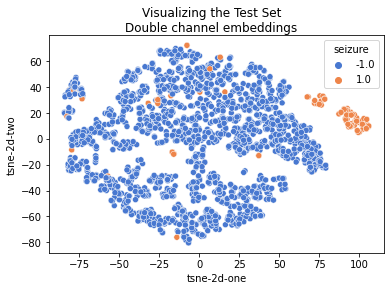

In [189]:
sns.scatterplot(data=double_results_df.query("label_desc == 'test'").sample(2000),
                x='tsne-2d-one', y='tsne-2d-two',
                # hue_order=hue_order,
                hue="seizure", palette="muted", legend=True)
plt.suptitle("Visualizing the Test Set\nDouble channel embeddings")
plt.show()

0.8614994325084706


Text(0.5, 1.0, 'ROC curve from Novelty Score\nSingle-channel segments')

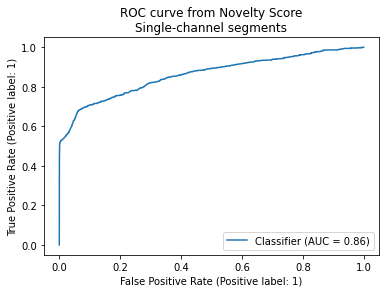

In [305]:
from sklearn.metrics import roc_auc_score

single_test = single_results_df.query("label_desc == 'test'")
print(roc_auc_score(single_test['seizure'], single_test['p_value']))
RocCurveDisplay.from_predictions(single_test['seizure'], single_test['p_value'])
plt.title("ROC curve from Novelty Score\nSingle-channel segments")

0.9869074395710917


Text(0.5, 1.0, 'ROC curve from Novelty score\nDouble-channel segments')

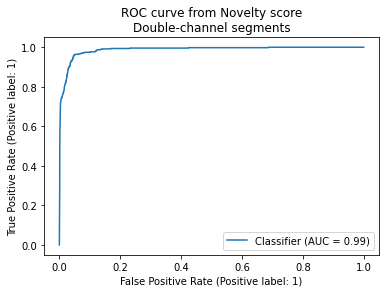

In [306]:
double_test = double_results_df.query("label_desc == 'test'")
print(roc_auc_score(double_test['seizure'], double_test['p_value']))
RocCurveDisplay.from_predictions(double_test['seizure'], double_test['p_value'])
plt.title("ROC curve from Novelty score\nDouble-channel segments")

## Evaluate SVM

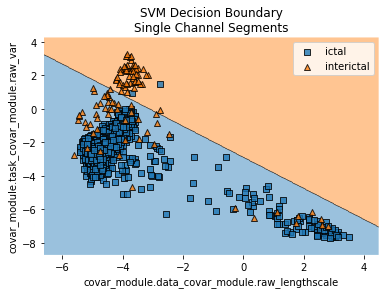

In [264]:
from sklearn.model_selection import train_test_split
from sklearn import svm, preprocessing
from mlxtend.plotting import plot_decision_regions

# encode labels
le = preprocessing.LabelEncoder()
le.fit(results_df.label_desc)
single_results_df["label"] = le.transform(single_results_df.label_desc)

# get all data
X = single_results_df.loc[single_results_df['label_desc'] == 'test', [single_channel_params[0], single_channel_params[2]]].sample(2000, random_state=42).to_numpy()
y = single_results_df.loc[single_results_df['label_desc'] == 'test', "seizure"].sample(2000, random_state=42).to_numpy().astype(np.int_)
y = np.where(y < 0, 0, y)

# split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# train a classifier
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

# plot decision regions
plot_decision_regions(X, y, clf=clf, legend=2)

# add axes annotations
plt.xlabel(single_channel_params[0])
plt.ylabel(single_channel_params[2])
plt.title('SVM Decision Boundary\nSingle Channel Segments')

# add legend
L = plt.legend()
L.get_texts()[0].set_text(le.classes_[0])
L.get_texts()[1].set_text(le.classes_[1])
plt.show()

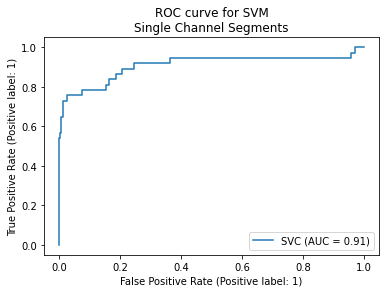

In [266]:
import sklearn

# plot ROC curve
sklearn.metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC curve for SVM\nSingle Channel Segments")
plt.show()

In [270]:

# get all data
X = double_results_df.loc[single_results_df['label_desc'] == 'test', double_channel_params].sample(2000, random_state=42).to_numpy()
y = double_results_df.loc[single_results_df['label_desc'] == 'test', "seizure"].sample(2000, random_state=42).to_numpy().astype(np.int_)
# y = np.where(y < 0, 0, y)

# split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# train a classifier
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

# plot ROC curve
sklearn.metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC curve for SVM\nDouble Channel Segments")
plt.show()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

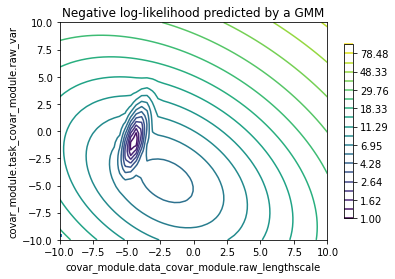

In [282]:
from matplotlib.colors import LogNorm


# selected label_desc parameters
X = single_results_df.loc[results_df["label_desc"] == 'interictal', [single_channel_params[0], single_channel_params[2]]].to_numpy()

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
clf.fit(X)

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
clf.fit(X)

# display predicted scores by the model as a contour plot
grid_size = 10.0
x = np.linspace(-grid_size, grid_size)
y = np.linspace(-grid_size, grid_size)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0), levels=np.logspace(0, 2, 20)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(X[:, 0], X[:, 1], 0.8)

# add axes annotations
plt.xlabel(single_channel_params[0])
plt.ylabel(single_channel_params[2])

# add title
plt.title("Negative log-likelihood predicted by a GMM")
plt.axis("tight")
plt.show()


In [349]:
sample = single_results_df.loc[single_results_df['seizure'] == -1].sample(1)

In [350]:
sample.seizure

22810   -1.0
Name: seizure, dtype: float64

In [351]:
ictality = sample.nll.item()

In [353]:
label = 'interictal'

In [352]:
ictality

1.8792394696258032

p_value=0.4355562200956938


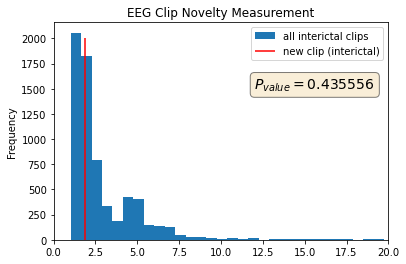

In [354]:
interictals = single_results_df.loc[single_results_df['label_desc'] == 'interictal']
# compute proportion of interictal clips with nll less than new clip (p-value)
interictals.loc[:, "nll"].plot(kind="hist", bins=100, label="all interictal clips")
plt.vlines(ictality, 0, 2000, colors="r", label=f"new clip ({label})")
plt.legend()
plt.xlim(0, 20)
p_value = (len(interictals[interictals["nll"] < ictality]))/(len(interictals))
textstr = r'$P_{value}=%.6f$' % (p_value)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax = plt.gca()
# place a text box in upper right in axes coords
ax.text(0.6, 0.75, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left',bbox=props)


plt.title("EEG Clip Novelty Measurement")
print(f"{p_value=}")